## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# setup 54 x 2 array of object points to map each location in 6 x 9 chessbord
# n = num of rows in chessboard
# k = num of cols in chessboard
# row | col
# j->n  i
# j->n  i+1
# j->n  i+k
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# loop through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners for each image
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) # add each map of obj points for each image in the objpoints list
        imgpoints.append(corners) # add each array of corner points for each image in the imgpoints list

        # Draw and display the corners found on each image
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret) 
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [8]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points of all images
# two lists of object points and image points for each image used to calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# use found camera matrix, distortion coefficents in order to undistort image
un_dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../camera_cal/test_undist.jpg',dist)# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

True

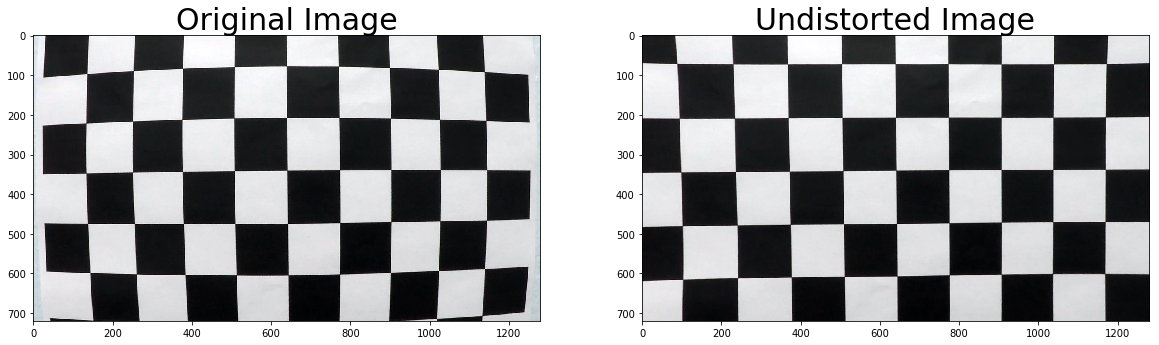

In [9]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(un_dst)
ax2.set_title('Undistorted Image', fontsize=30)

plt.savefig('Undistorted_Result.jpg')

## Second, I'll create a binary threshold by using gradients and color transforms


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
#%matplotlib inline
#import glob


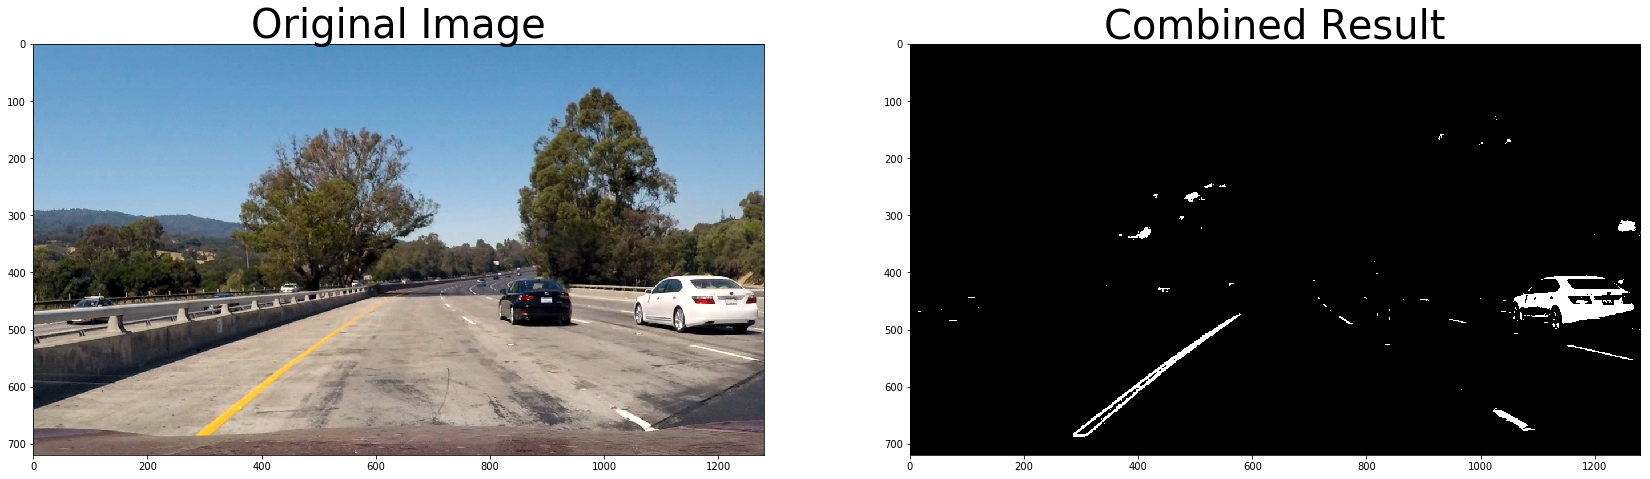

In [11]:
def binary_threshold(img, s_thresh=(180, 255), l_thresh=(225, 255), b_thresh=(155, 200)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    l_channel = luv[:,:,0]
 
    #lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    #b_channel = #lab[:,:,2]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x on gray scale of image
    #scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y on gray scale of image
    gradmag = np.sqrt(sobelx**2 + sobely**2)
   # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
       
    # Threshold light channel to be more robust to shadows
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1   
    
    # Threshold yellow colors
    b_binary = np.zeros_like(b_channel)

    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1  

    # Threshold saturation/color channel to detect both yellow/white lines
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
#     # Stack each channel with G and B channels corresponding to x gradient, saturation, light channel results
#     zero_channel = np.zeros_like(sxbinary)
#     color_binary = np.dstack((zero_channel, sxbinary, s_binary)) * 255
    #print(c_binary)
    #print(np.where(c_binary))
    #print(np.where(l_binary))
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1

    return combined_binary

#image = mpimg.imread('../test_images/test1.jpg')
image = cv2.imread('../test_images/test1.jpg')
com_binary = binary_threshold(image)

f, (ax1, ax3) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax3.imshow(com_binary, cmap='gray')
ax3.set_title('Combined Result', fontsize=40)
plt.subplots_adjust(left=0.03, right=0.96, top=0.9, bottom=0.)

plt.savefig('Threshold_Result.jpg')

## Next, I'll apply a perspective transform

In [11]:
image = mpimg.imread('../test_images/test1.jpg')

In [4]:
def warper(img, src, dst):

    # Compute and apply perspective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

img_size = (image.shape[1], image.shape[0])

# get source and dest pts
# adjust to capture lane lines
src = np.float32(
    [[(img_size[0] / 2) - 70, img_size[1] / 2 + 118],
    [((img_size[0] / 6) + 30), img_size[1]],
    [(img_size[0] * 5 / 6) + 100, img_size[1]],
    [(img_size[0] / 2 + 120), img_size[1] / 2 + 118]])

print(src)

# remap to rectangle for full top down view of lines
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

top_down = warper(image,src,dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax1.add_patch(patches.Polygon(src,closed=True,fill=False,lw=3.0,color='r'))

ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=50)
ax2.add_patch(patches.Polygon(dst,closed=True,fill=False,lw=3.0,color='r'))

plt.subplots_adjust(left=0.04, right=0.95, top=0.9, bottom=0.)

plt.savefig('Warped_Result.jpg')

[[  570.           478.        ]
 [  243.33332825   720.        ]
 [ 1166.66662598   720.        ]
 [  760.           478.        ]]


## Next, I apply a sliding window search through a convolution to identify the lane lines.

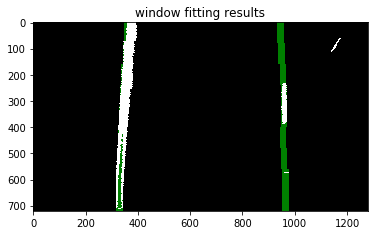

In [57]:
# window settings
window_width = 25 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 5 # How much to slide left and right for searching

def process_image(image,src,dst):
    image = cv2.undistort(image, mtx, dist, None, mtx) # undistort with camera calibration   
    image = binary_threshold(image) # run binary threshold
    image = warper(image,src,dst) # run perspective transform
    
    return image

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    #print(l_sum.shape)
    #print(window.shape)
    
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids

#image = mpimg.imread('../test_images/test1.jpg')
image = cv2.imread('../test_images/test6.jpg')

warp_image = process_image(image,src, dst)

window_centroids = find_window_centroids(warp_image, window_width, window_height, margin)

def find_left_right_points(image, window_centroids, window_width, window_height):   
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
           # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
           # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((image, image, image))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image,image,image)),np.uint8)
    
    return output, l_points, r_points

output, l_points, r_points = find_left_right_points(warp_image, window_centroids, window_width, window_height)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
plt.savefig('Window_Fit_Result.jpg')


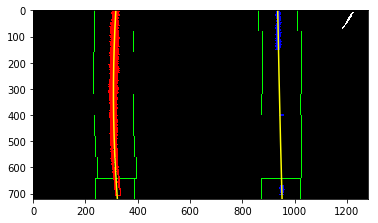

In [12]:
def process_image(image,src,dst):
    image = cv2.undistort(image, mtx, dist, None, mtx) # undistort with camera calibration   
    image = binary_threshold(image) # run binary threshold
    image = warper(image,src,dst) # run perspective transform
    
    return image

image = cv2.imread('../test_images/test1.jpg')

warp_image = process_image(image,src, dst)

binary_warped = warp_image

def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    isLeftLineDetected = (leftx.size > 0 and lefty.size > 0)
    isRightLineDetected = (righty.size > 0 and rightx.size > 0)    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left = np.zeros((len(left_lane_inds),2))
    right = np.zeros((len(right_lane_inds),2))
    
    left[:,1] = leftx
    left[:,0] = lefty

    right[:,1] = rightx
    right[:,0] = righty    
    
    return left, right, left_fitx, right_fitx, ploty, left_fit, right_fit, isLeftLineDetected, isRightLineDetected, out_img

left, right, left_fitx, right_fitx, ploty, left_fit, right_fit, isLeftLineDetected, isRightLineDetected, out_img = sliding_window(binary_warped)

#()

# Create an output image to draw on and  visualize the result
out_img[left[:,0].astype(int), left[:,1].astype(int)] = [255, 0, 0]
out_img[right[:,0].astype(int), right[:,1].astype(int)] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('New_PolyFit_Result.jpg')

## Next, I fit a polynomial to the pixels identified in the sliding window.

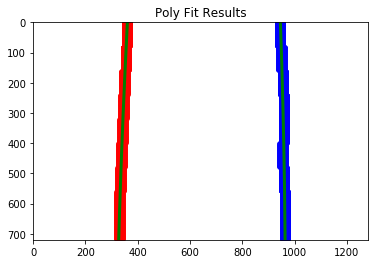

In [67]:
def fitpolypixels(l_points, r_points):
    # I get the pixel locations of each lane line 
    left = np.argwhere(l_points == 255) # y,x
    right = np.argwhere(r_points == 255)

    # Fit a second order polynomial to pixel positions in each lane line
    left_fit = np.polyfit(left[:,0], left[:,1], 2) # y,x
    left_fitx = left_fit[0]*left[:,0]**2 + left_fit[1]*left[:,0] + left_fit[2]
    right_fit = np.polyfit(right[:,0], right[:,1], 2)
    right_fitx = right_fit[0]*right[:,0]**2 + right_fit[1]*right[:,0] + right_fit[2]

    return left, right, left_fitx, right_fitx, left_fit, right_fit

#print(l_points.shape)
#print(np.argwhere(l_points == 255).shape)

left, right, left_fitx, right_fitx, left_fit, right_fit = fitpolypixels(l_points, r_points)

# Plot up the  data
mark_size = 3
plt.plot(left[:,1], left[:,0], 'o', color='red', markersize=mark_size)
plt.plot(right[:,1], right[:,0], 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, left[:,0], color='green', linewidth=3)
plt.plot(right_fitx, right[:,0], color='green', linewidth=3)
plt.gca().invert_yaxis()
plt.title('Poly Fit Results')
plt.savefig('PolyFit_Result.jpg')

In [13]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def simpleLaneFinder(binary_warped, left_fit, right_fit):
    # I get the pixel locations of the original lane line 
    #orig_left = np.argwhere(l_points == 255) # y,x
    #orig_right = np.argwhere(r_points == 255)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
   
    nonzero = binary_warped.nonzero()
    #print(nonzero.shape)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 165
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left = np.zeros((len(leftx),2))
    right = np.zeros((len(rightx),2))    
    
    left[:,1] = leftx
    left[:,0] = lefty

    right[:,1] = rightx
    right[:,0] = righty     
    
    isLineDetected = (leftx.size > 0 and lefty.size > 0 and righty.size > 0 and rightx.size > 0)
    left_fit = []
    right_fit = []
    left_fitx = []
    right_fitx = []    
    if isLineDetected:
    # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #left_fitx = left_fit[0]*orig_left[:,0]**2 + left_fit[1]*orig_left[:,0] + left_fit[2]
        #right_fitx = right_fit[0]*orig_right[:,0]**2 + right_fit[1]*orig_right[:,0] + right_fit[2]            
    
    return left, right, left_fitx, right_fitx, ploty, left_fit, right_fit, isLineDetected

In [14]:
def get3pointRadius(x1,y1,x2,y2,x3,y3):
    m1 = (y2-y1)/(x2-x1)
    m2 = (y3-y2)/(x3-x2)
    xc = (m1*m2*(y1-y3)+m2*(x1+x2)-m1*(x2+x3))/(2*(m2-m1))
    yc = -(xc-(x1+x2)/2)/m1 +(y1+y2)/2      
          
    radius = np.sqrt((x2-xc)**2+(y2-yc)**2)
          
    return radius

In [15]:
def calcRadiusCurv(left, right, left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(left[:,0]*ym_per_pix, left[:,1]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right[:,0]*ym_per_pix, right[:,1]*xm_per_pix, 2)    
    
    y_min = np.min(left[:,0]*ym_per_pix) # min y
    y_mean = np.mean(left[:,0]*ym_per_pix) # mean y
    y_max = np.max(left[:,0]*ym_per_pix) # max y
    
    leftx_min = np.polyval(left_fit_cr,y_min)
    leftx_mean = np.polyval(left_fit_cr,y_mean)
    leftx_max = np.polyval(left_fit_cr,y_max)
    rightx_min = np.polyval(right_fit_cr,y_min)
    rightx_mean = np.polyval(right_fit_cr,y_mean)
    rightx_max = np.polyval(right_fit_cr,y_max)
   
    # calculate the curvature with 3 min, mean and max points of the image
    left_curverad = get3pointRadius(leftx_min,y_min,leftx_mean,y_mean,leftx_max,y_max)
    right_curverad = get3pointRadius(rightx_min,y_min,rightx_mean,y_mean,rightx_max,y_max)
    
    return left_curverad, right_curverad

In [16]:
def drawPolygon(warp_image, image, undist, dst, src, leftx, rightx, ploty, left_curverad, right_curverad):
    # Draw on Polygon back onto original image

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Mi = cv2.getPerspectiveTransform(dst, src)

    left_mean = np.mean(leftx) # get avg of left lane pixels
    right_mean = np.mean(rightx) # get avg of right lane pixels
    vehicle_pos = (image.shape[1]/2)-np.mean([left_mean, right_mean]) # assume camera pos is center of image. vehicle pos w.r.t. vehicle lane
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
     
    avg_curv = (left_curverad+right_curverad)/2    
        
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Mi, (image.shape[1], image.shape[0])) 
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1.2
    fontColor = (255,255,255) # white 
    thickness = 4
    if vehicle_pos > 0:
        cv2.putText(newwarp,'Vehicle Position' + ' is ' + str(vehicle_pos*xm_per_pix)[:5] + ' m Right of Center',(10,30), font, fontscale, fontColor,thickness)
    else:
        cv2.putText(newwarp,'Vehicle Position' + ' is ' + str(np.abs(vehicle_pos*xm_per_pix))[:5] + ' m Left of Center',(10,30), font, fontscale, fontColor,thickness)        
    
    cv2.putText(newwarp,'Radius of Curvature = ' +str(avg_curv)[:5] + ' m' ,(10,80), font, fontscale,fontColor,thickness)

    # Combine the result with the original image
    undist = cv2.undistort(image, mtx, dist, None, mtx) # undistort with camera calibration   
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # number of iterations
        self.n_iterations = 0
        self.current_fitx = None
        self.basepts = None
        self.slope_ours = 0

    def compareLines(self,x,y):
        slope_theirs = np.abs((y[0]-y[-1])/(x[0]-x[-1]))
        self.slope_ours = np.abs((self.ally[0]-self.ally[-1])/(self.allx[0]-self.allx[-1]))
        diff = np.abs(self.slope_ours-slope_theirs)
        if (diff > 50):
            self.detected = False          
        else:
            self.detected = True
                      
    def setbasepts(self,basepts):
        self.basepts = basepts

    def setdiffs(self,new_coeff):
        self.diffs = newcoeff-self.current_fit
        
    def setcurrentfitx(self,current_fitx):
        self.current_fitx = current_fitx
        
    def setcurrentfit(self,current_fit):
        self.current_fit = current_fit
        if (False not in self.current_fit): 
            self.detected = True
        else:
            self.detected = False       
    
    def set_radius_of_curvative(self,radius_of_curvature):
        self.set_radius_of_curvative = radius_of_curvature
        
    def isLineDetected(self):
        return self.detected    
        
    def setLineBasPos(self,line_base_pos):
        self.line_base_pos = line_base_pos
        
    def setxypixels(self,allx,ally):
        self.allx = allx
        self.ally = ally
        if (len(self.recent_xfitted) < 10):
            self.recent_xfitted.append(allx) # append current fit to recent fit
        else:
            self.recent_xfitted[0] = allx # replace oldest in, with latest in, FIFO, first in, first out
            np.roll(self.recent_xfitted,-1) # shift list back so oldest is in first position

    def updateBestX(self): # update average best fit
        if self.bestx is None:
            self.bestx = self.allx
        else:  
            if self.n_iterations < 10:
                self.n_iterations += 1              
            self.bestx = sum(self.recent_xfitted) / (self.n_iterations)
              
    def updateBestFit(self): # update average best fit
        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = np.polyfit(self.ally, self.bestx, 2) # do a new fit on the average x values of n iterations
        

In [18]:
class cameraData(): # Class of camera Data
    def __init__(self):
        self.dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )  
        self.mtx = self.dist_pickle['mtx']
        self.dist = self.dist_pickle['dist']   

class warpData(): # Class of warp Data
    def __init__(self,img_size=0):
        self.src = np.float32(
            [[(img_size[0] / 2) - 85+15, img_size[1] / 2 + 118],
            [((img_size[0] / 6) + 30), img_size[1]],
            [(img_size[0] * 5 / 6) + 100, img_size[1]],
            [(img_size[0] / 2 + 120), img_size[1] / 2 + 118]])
        self.dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])


In [19]:
def pipeline(image): 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)    
    img_size = (image.shape[1], image.shape[0])    
    cameraInst = cameraData() # get camera Data
    warpInst = warpData(img_size) # get warp Data
    undist = cv2.undistort(image, cameraInst.mtx, cameraInst.dist, None, cameraInst.mtx) # undistort with camera calibration   
    bi_image = binary_threshold(undist) # run binary threshold
    warp_image = warper(bi_image,warpInst.src,warpInst.dst) # run perspective transform
    previousLineDetected = (leftLine.isLineDetected() and rightLine.isLineDetected())
    #isLinedetected = True
    #print(previousLineDetected)
    if (previousLineDetected):
        left_pts, right_pts, left_fitx, right_fitx, ploty, left_fit, right_fit, isLinedetected = simpleLaneFinder(warp_image, leftLine.current_fit, rightLine.current_fit)
        leftLine.detected = isLinedetected
        rightLine.detected = isLinedetected        
        #previousLineDetected = (leftLine.isLineDetected() and rightLine.isLineDetected())  
    if (not leftLine.detected or not rightLine.detected): 
        #window_width = 25
        #window_height = 80 # Break image into 9 vertical layers since image height is 720
        #margin = 5 # How much to slide left and right for searching    
        #window_centroids = find_window_centroids(warp_image, window_width, window_height, margin) # find window centroids
        #output, l_points, r_points = find_left_right_points(warp_image, window_centroids, window_width, window_height) # find left right lanes
        #left_pts, right_pts, left_fitx, right_fitx, left_fit, right_fit = fitpolypixels(l_points, r_points) # get polynomial fit of lanes   
        left_pts, right_pts, left_fitx, right_fitx, ploty, left_fit, right_fit, leftLine.detected, rightLine.detected, out = sliding_window(warp_image)        
        #leftLine.setbasepts(l_points)
        #rightLine.setbasepts(r_points)
#     print(left_fitx.shape)
#     print(ploty.shape)

    if(leftLine.detected):
        # update left/right lane class data
        leftLine.setcurrentfit(left_fit)
        leftLine.setcurrentfitx(left_fitx)
    #leftLine.setxypixels(left_pts[:,1],left_pts[:,0])
#     leftLine.updateBestX()
#     leftLine.updateBestFit()

    if(rightLine.detected):
        rightLine.setcurrentfit(right_fit)
        rightLine.setcurrentfitx(right_fitx)
    #rightLine.setxypixels(right_pts[:,1],right_pts[:,0])
#    rightLine.compareLines(leftLine.allx,leftLine.ally) 
#    leftLine.compareLines(rightLine.allx,rightLine.ally)
    #print(rightLine.slope_ours)
    #print(leftLine.slope_ours)
    
#     rightLine.updateBestFit()
    

    left_curverad, right_curverad = calcRadiusCurv(left_pts, right_pts, leftLine.current_fit, rightLine.current_fit) #add radius of curvature calculation
    result = drawPolygon(warp_image, image, undist, warpInst.dst, warpInst.src, leftLine.current_fitx, rightLine.current_fitx, ploty, left_curverad, right_curverad) #add final image augmentation 
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

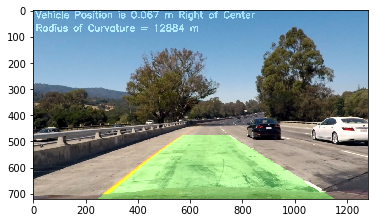

In [20]:
leftLine = Line()
rightLine = Line()
image = mpimg.imread('../test_images/test1.jpg')
#image = cv2.imread('../test_images/test4.jpg')
result = pipeline(image)
plt.imshow(result)
plt.savefig('Output_Result.jpg')

3260.12332297
2301.2607989


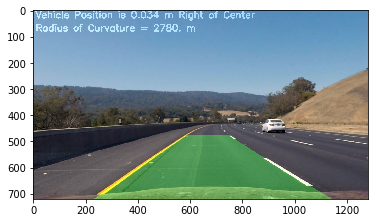

In [56]:
leftLine = Line()
rightLine = Line()
image = mpimg.imread('../test_images/test3.jpg')
result = pipeline(image)
plt.imshow(result)

0
[[ 640.  300.]
 [ 640.  301.]
 [ 640.  302.]
 ..., 
 [  79.  372.]
 [  79.  373.]
 [  79.  374.]]
[[ 640.  932.]
 [ 640.  933.]
 [ 640.  934.]
 ..., 
 [  79.  937.]
 [  79.  938.]
 [  79.  939.]]
1
[[   0.  305.]
 [   0.  306.]
 [   0.  307.]
 ..., 
 [ 707.  342.]
 [ 707.  343.]
 [ 707.  344.]]
[[  22.  947.]
 [  22.  948.]
 [  22.  949.]
 ..., 
 [ 646.  959.]
 [ 647.  958.]
 [ 647.  959.]]
2
[[ 161.  251.]
 [ 161.  252.]
 [ 161.  253.]
 ..., 
 [ 713.  267.]
 [ 713.  268.]
 [ 713.  269.]]
[[  74.  927.]
 [  74.  928.]
 [  74.  929.]
 ..., 
 [ 629.  942.]
 [ 629.  943.]
 [ 629.  944.]]
3
[[   0.  359.]
 [   0.  360.]
 [   0.  361.]
 ..., 
 [ 710.  334.]
 [ 710.  336.]
 [ 710.  337.]]
[[ 232.  956.]
 [ 232.  957.]
 [ 232.  958.]
 ..., 
 [ 576.  971.]
 [ 576.  972.]
 [ 576.  973.]]


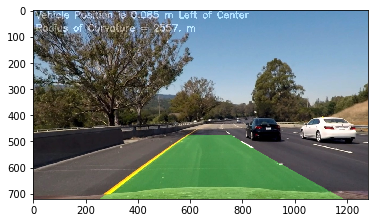

In [72]:
leftLine = Line()
rightLine = Line()
image_list = []
image_list.append('../test_images/test3.jpg')
image_list.append('../test_images/test4.jpg')
image_list.append('../test_images/test5.jpg')
image_list.append('../test_images/test6.jpg')
# image = mpimg.imread('../test_images/test4.jpg')

for num, img in enumerate(image_list):
    print(num)
    img = mpimg.imread(img)   
    result = process_img(img)
    plt.imshow(result)   

In [57]:
def process_img(image):
    #image = cv2.imread(image)
    image = pipeline(image) # add full pipeline to image
    return image

In [58]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [97]:
project_video_output = '../project_video_24_26_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
leftLine = Line()
rightLine = Line()
clip1 = VideoFileClip("../project_video.mp4").subclip(0,50)
clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ../project_video_24_26_test.mp4
[MoviePy] Writing video ../project_video_24_26_test.mp4



 24%|██▍       | 303/1251 [01:04<03:17,  4.80it/s]


 48%|████▊     | 605/1251 [02:07<02:22,  4.52it/s]


 73%|███████▎  | 907/1251 [03:11<01:10,  4.85it/s]


 96%|█████████▋| 1205/1251 [04:13<00:09,  4.80it/s]


100%|█████████▉| 1250/1251 [04:23<00:00,  4.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_24_26_test.mp4 

CPU times: user 5min 13s, sys: 41.4 s, total: 5min 55s
Wall time: 4min 24s


In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))